C:\ProgramData\Anaconda3\envs\trading\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


data reading from file...


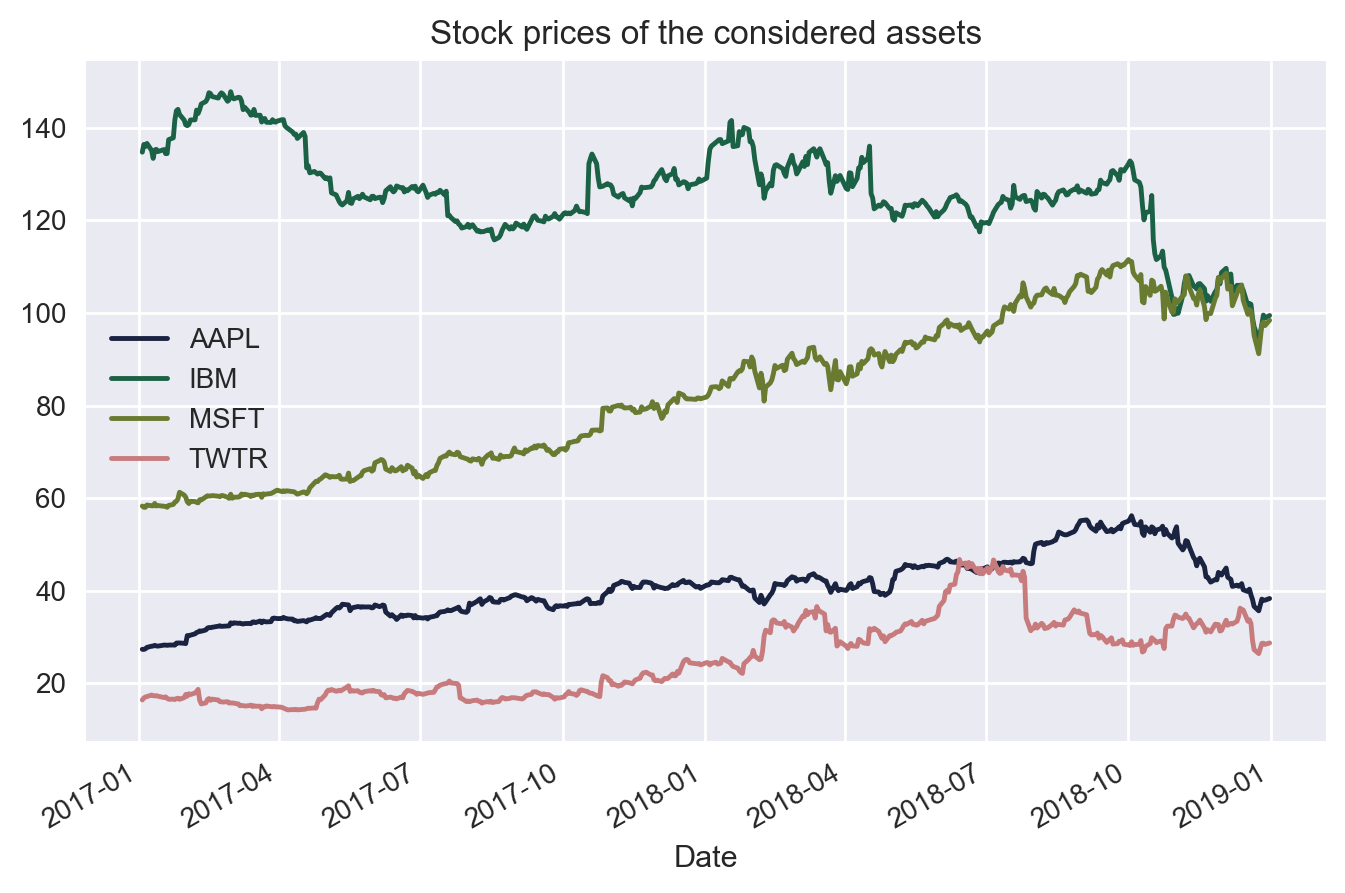

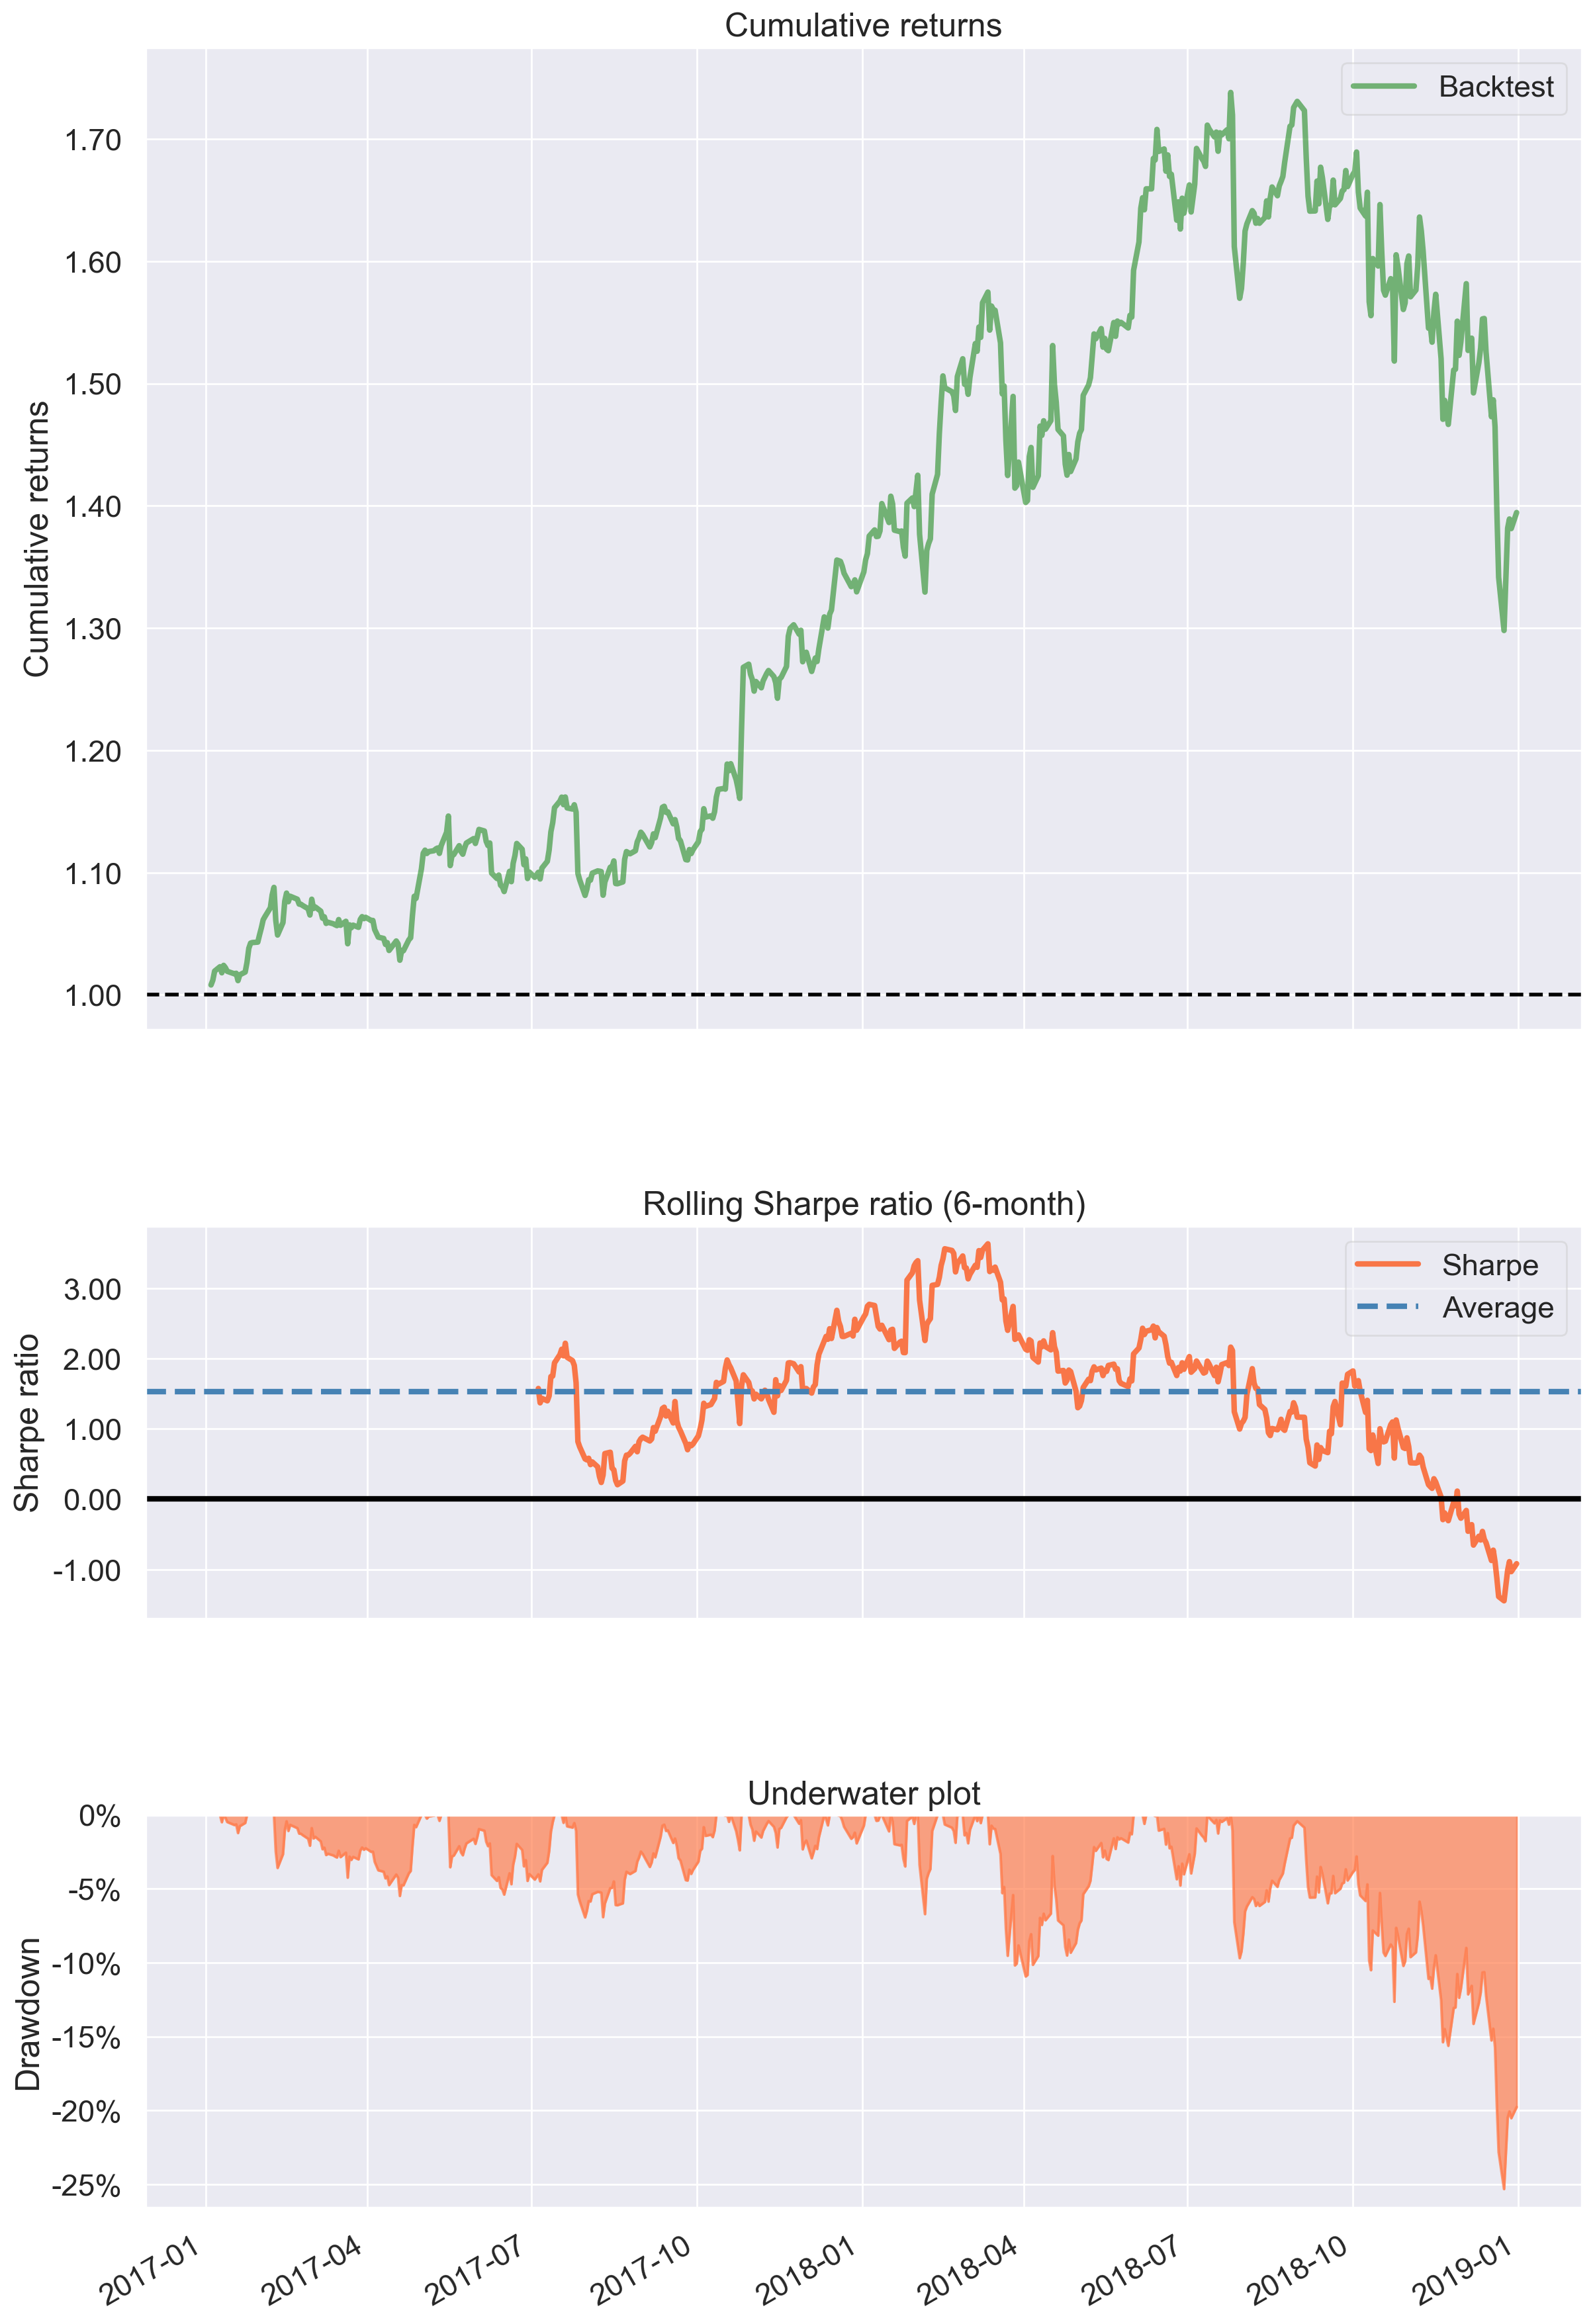

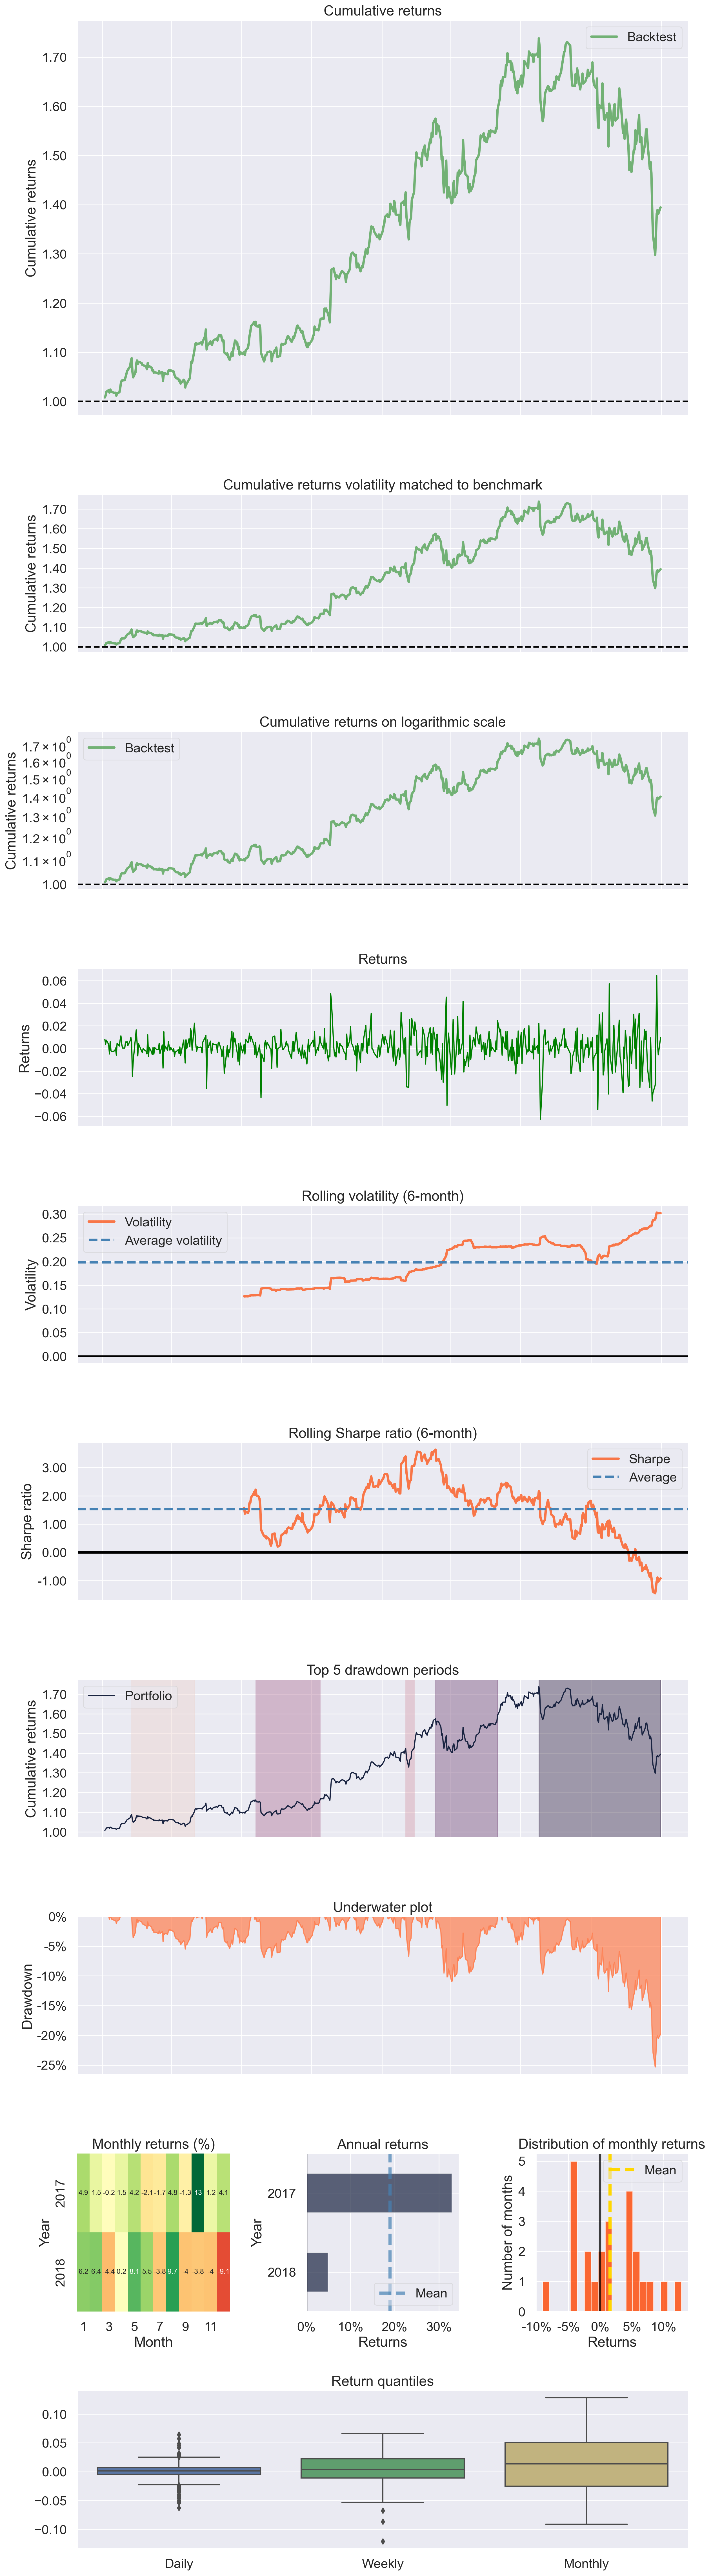

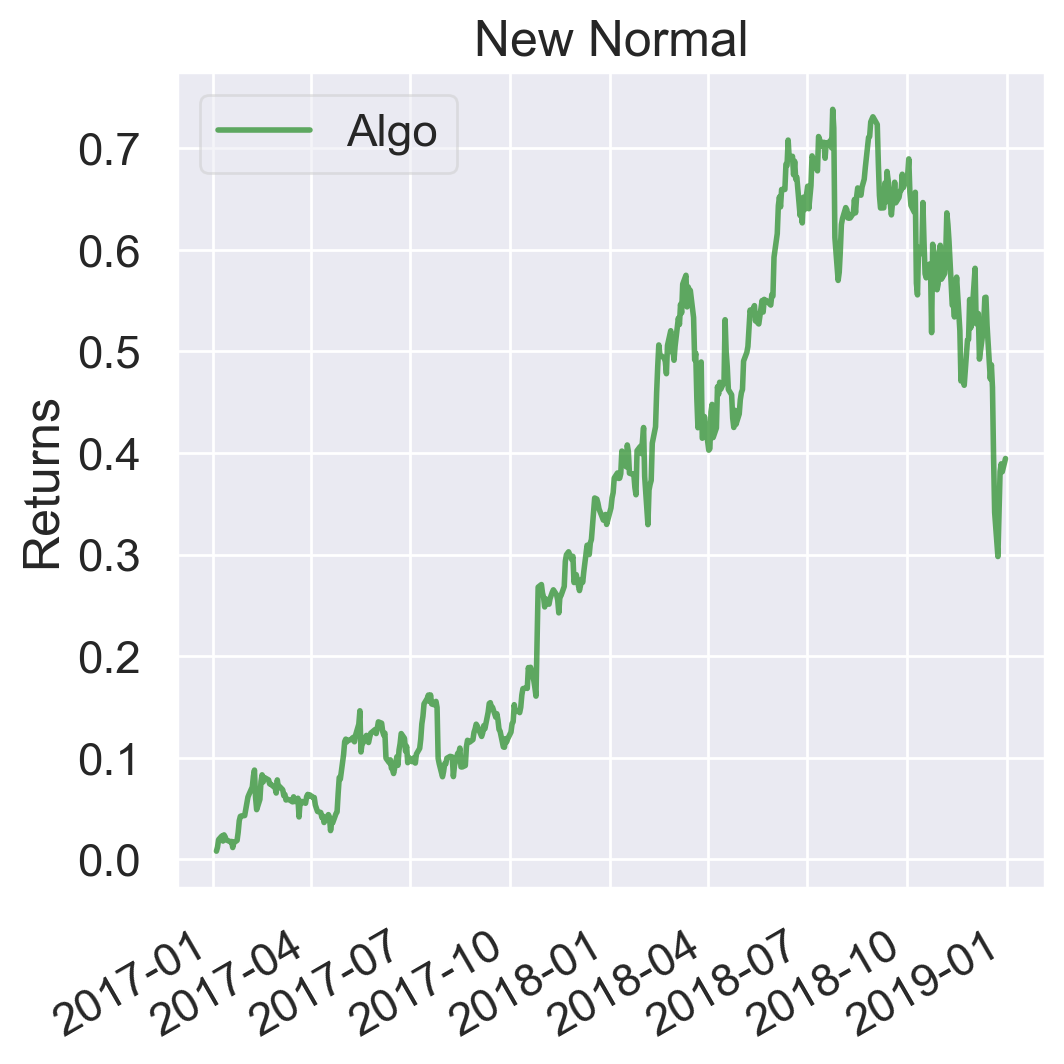

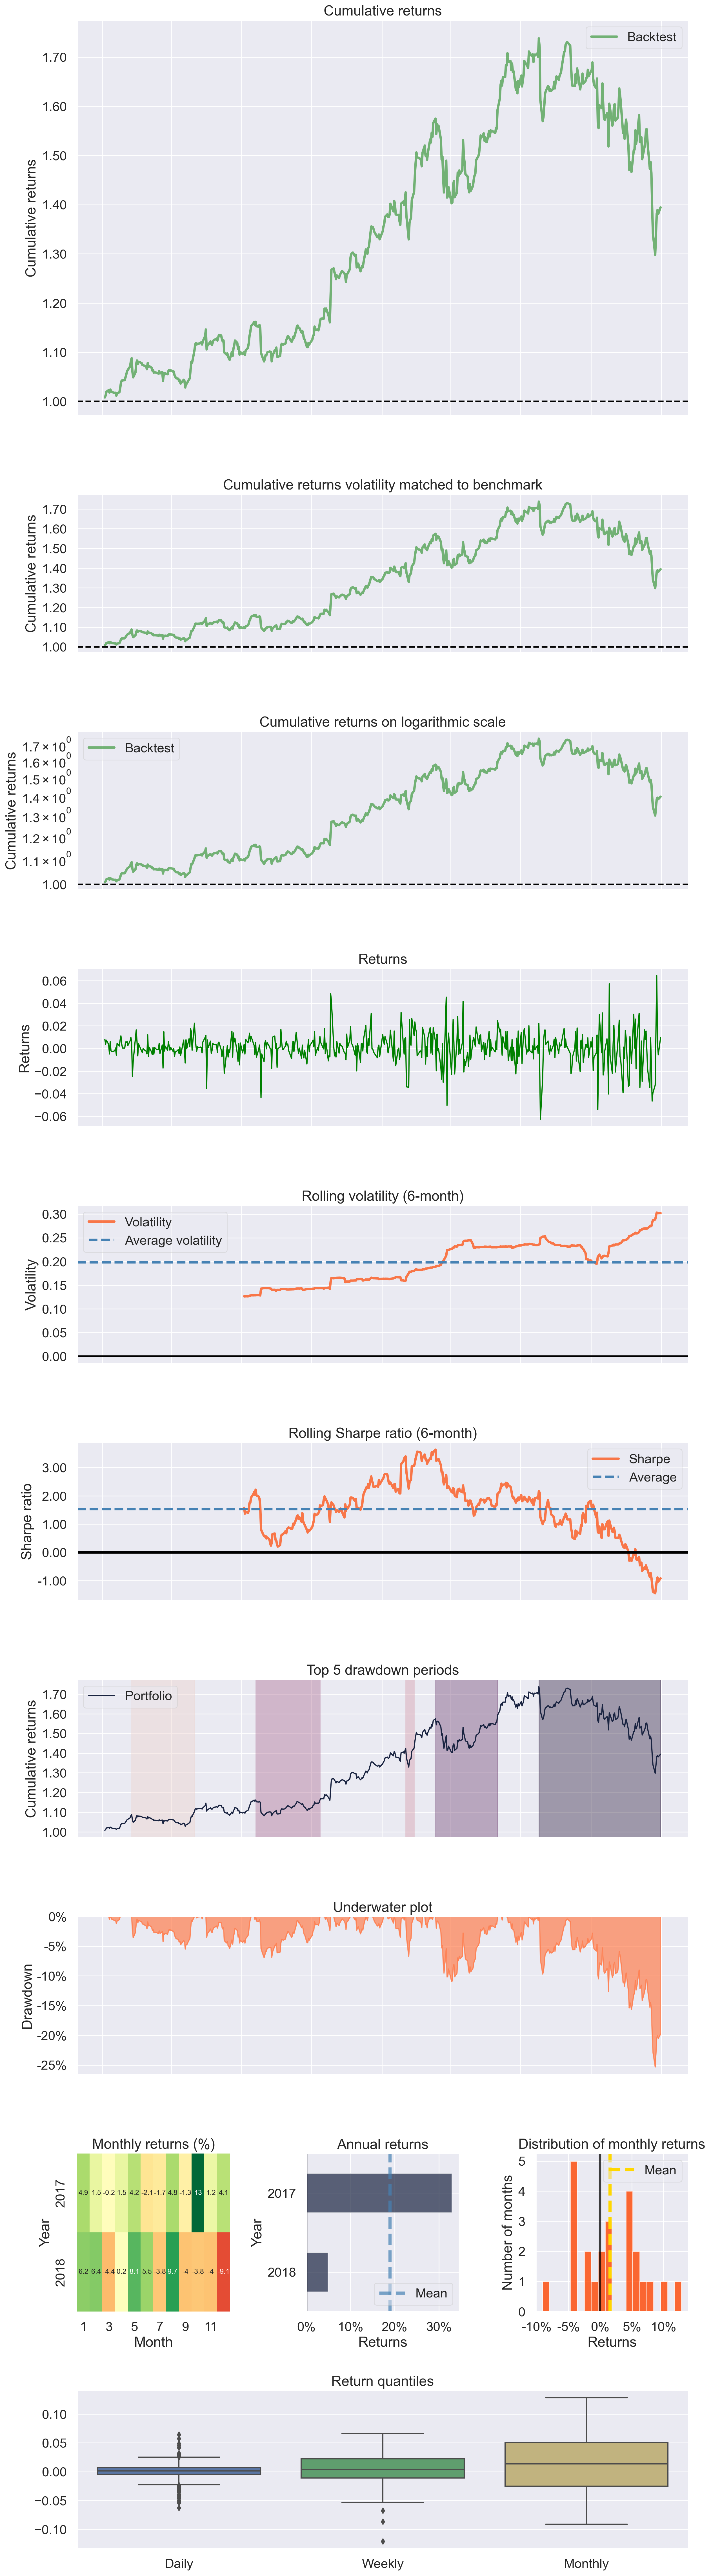

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pyfolio as pf

from datetime import datetime

plt.style.use("seaborn")
sns.set_palette("cubehelix")
plt.rcParams["figure.figsize"] = [8, 5]
plt.rcParams["figure.dpi"] = 200
warnings.simplefilter(action="ignore", category=FutureWarning)

risky_assets = ["AAPL", "IBM", "MSFT", "TWTR"]
n_assets = len(risky_assets)
start = datetime(2017, 1, 1)
end = datetime(2020, 12, 31)
src_data = "data/yf_assets_c07_1.pkl"
try:
    data = pd.read_pickle(src_data)
    print("data reading from file...")
except FileNotFoundError:
    data = yf.download(risky_assets, start=start, end=end, adjusted=True, progress=False)
    data.to_pickle(src_data)
prices_df = data["2017":"2018"]

prices_df["Adj Close"].plot(title="Stock prices of the considered assets")
plt.savefig("images/ch7_im101.png")

returns = prices_df["Adj Close"].pct_change().dropna()
portfolio_weights = n_assets * [1 / n_assets]
portfolio_returns = pd.Series(np.dot(portfolio_weights, returns.T), index=returns.index)

pf.create_simple_tear_sheet(portfolio_returns)
pf.create_full_tear_sheet(portfolio_returns)
fig = pf.create_returns_tear_sheet(portfolio_returns, return_fig=True)
fig.savefig("images/ch7_im102.png", dpi=300)

In [1]:
## Building an Interactive Dashboard for Technical Analysis
import ipywidgets as wd
from ipywidgets import interact, interact_manual
import cufflinks as cf
import pandas as pd
import yfinance as yf
from plotly.offline import iplot, init_notebook_mode

stocks = ["TWTR", "MSFT", "GOOGL", "FB", "TSLA", "AAPL"]
indicators = ["Bollinger Bands", "MACD", "RSI"]

def ta_dashboard(
    asset,
    indicator,
    start_date,
    end_date,
    bb_k,
    bb_n,
    macd_fast,
    macd_slow,
    macd_signal,
    rsi_periods,
    rsi_upper,
    rsi_lower,
):

    df = yf.download(asset, start=start_date, end=end_date, progress=False, auto_adjust=True)
    qf = cf.QuantFig(df, title=f"TA Dashboard - {asset}", legend="right", name=f"{asset}")
    if "Bollinger Bands" in indicator:
        qf.add_bollinger_bands(periods=bb_n, boll_std=bb_k)
    if "MACD" in indicator:
        qf.add_macd(fast_period=macd_fast, slow_period=macd_slow, signal_period=macd_signal)
    if "RSI" in indicator:
        qf.add_rsi(
            periods=rsi_periods, rsi_upper=rsi_upper, rsi_lower=rsi_lower, showbands=True
        )
    return qf.iplot()

stocks_selector = wd.Dropdown(options=stocks, value=stocks[0], description="Asset")
indicator_selector = wd.SelectMultiple(
    description="Indicator", options=indicators, value=[indicators[0]]
)
start_date_selector = wd.DatePicker(
    description="Start Date", value=pd.to_datetime("2018-01-01"), continuous_update=False
)
end_date_selector = wd.DatePicker(
    description="End Date", value=pd.to_datetime("2018-12-31"), continuous_update=False
)
main_selector_label = wd.Label("Main parameters", layout=wd.Layout(height="45px"))
main_selector_box = wd.VBox(
    children=[
        main_selector_label,
        stocks_selector,
        indicator_selector,
        start_date_selector,
        end_date_selector,
    ]
)

bb_label = wd.Label("Bollinger Bands")
n_param = wd.IntSlider(
    value=20, min=1, max=40, step=1, description="N:", continuous_update=False
)
k_param = wd.FloatSlider(
    value=2, min=0.5, max=4, step=0.5, description="k:", continuous_update=False
)
bollinger_box = wd.VBox(children=[bb_label, n_param, k_param])

macd_label = wd.Label("MACD")
macd_fast = wd.IntSlider(
    value=12, min=2, max=50, step=1, description="Fast avg:", continuous_update=False
)
macd_slow = wd.IntSlider(
    value=26, min=2, max=50, step=1, description="Slow avg:", continuous_update=False
)
macd_signal = wd.IntSlider(
    value=9, min=2, max=50, step=1, description="MACD signal:", continuous_update=False
)
macd_box = wd.VBox(children=[macd_label, macd_fast, macd_slow, macd_signal])

rsi_label = wd.Label("RSI")
rsi_periods = wd.IntSlider(
    value=14, min=2, max=50, step=1, description="RSI periods:", continuous_update=False
)
rsi_upper = wd.IntSlider(
    value=70, min=1, max=100, step=1, description="Upper Thr:", continuous_update=False
)
rsi_lower = wd.IntSlider(
    value=30, min=1, max=100, step=1, description="Lower Thr:", continuous_update=False
)
rsi_box = wd.VBox(children=[rsi_label, rsi_periods, rsi_upper, rsi_lower])

sec_selector_label = wd.Label("Secondary parameters", layout=wd.Layout(height="45px"))
blank_label = wd.Label("", layout=wd.Layout(height="45px"))
sec_box_1 = wd.VBox([sec_selector_label, bollinger_box, macd_box])
sec_box_2 = wd.VBox([blank_label, rsi_box])
secondary_selector_box = wd.HBox([sec_box_1, sec_box_2])

controls_dict = {
    "asset": stocks_selector,
    "indicator": indicator_selector,
    "start_date": start_date_selector,
    "end_date": end_date_selector,
    "bb_k": k_param,
    "bb_n": n_param,
    "macd_fast": macd_fast,
    "macd_slow": macd_slow,
    "macd_signal": macd_signal,
    "rsi_periods": rsi_periods,
    "rsi_upper": rsi_upper,
    "rsi_lower": rsi_lower,
}
ui = wd.HBox([main_selector_box, secondary_selector_box])
out = wd.interactive_output(ta_dashboard, controls_dict)

display(ui, out)

Output()